In [1]:
import pyglet
import pyrender
import numpy as np
import trimesh
import trimesh
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
import open3d as o3d
import time
import sys,os

from scipy.spatial import KDTree
from scipy.sparse import diags
from scipy.sparse.linalg import svds

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 1

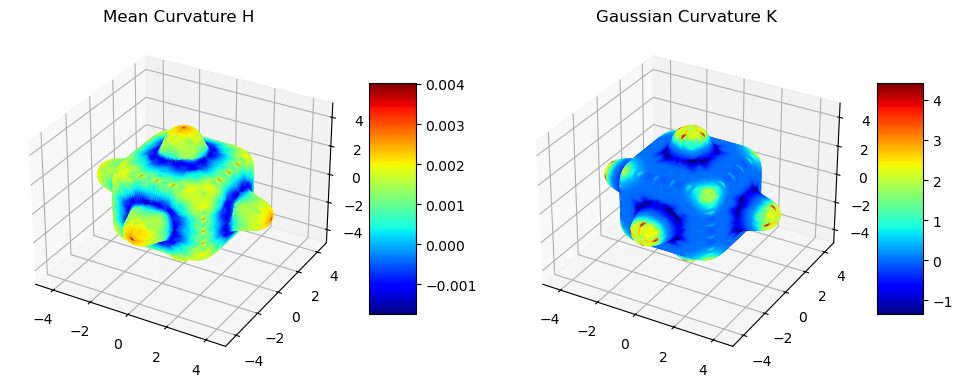

Mean Curvature H: [0.00104645 0.00256149 0.00256149 ... 0.0010222  0.00123956 0.00108484]
Gaussian Curvature K: [ 1.10985307 -0.11453097 -0.11453097 ... -0.51860664 -0.37859726
 -0.61227475]


In [175]:
RES_PATH = 'meshes'
mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src
from mpl_toolkits.mplot3d import Axes3D

# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)


# 函数计算每个顶点的邻居
def get_vertex_neighbors(faces):
    vertex_neighbors = {}
    for face in faces:
        for i in range(3):
            if face[i] not in vertex_neighbors:
                vertex_neighbors[face[i]] = []
            # 这里将NumPy数组转换为列表进行连接操作,合并当前顶点前面和后面的点
            vertex_neighbors[face[i]].extend(list(face[:i]) + list(face[i+1:]))
            # print(face)
            # print(i, face[i], face[:i], face[i+1:])
    # 删除重复项
    for vertex in vertex_neighbors:
        vertex_neighbors[vertex] = list(set(vertex_neighbors[vertex]))
    return vertex_neighbors

# 计算每个顶点的均质曲率H
def compute_mean_curvature(vertices, vertex_neighbors, normals):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        # print(i, vertex_neighbors[i])
        L = np.sum(neighbor_vectors, axis=0) / len(neighbor_vectors)
        # H[i] = np.linalg.norm(L) / 2
        H[i] = - np.dot(L, normals[i]) / 2
    return H

def triangle_area(vertex1, vertex2, vertex3):
    # 根据三角形三个顶点的坐标计算面积
    # 使用海伦公式，首先计算三边长度
    a = np.linalg.norm(vertex1 - vertex2)
    b = np.linalg.norm(vertex2 - vertex3)
    c = np.linalg.norm(vertex3 - vertex1)
    
    # 计算半周长
    s = (a + b + c) / 2
    
    # 计算面积
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

# 肉眼观察法这个应该算对了？
# https://blog.csdn.net/yinhun2012/article/details/112719305
def calculate_triangle_out_circle_center(A, B, C):
    # Convert input lists to NumPy arrays if they aren't already
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)

    # Calculate the vectors representing the sides of the triangle
    AB = B - A
    AC = C - A
    
    # Calculate the normal vector of the plane defined by the triangle
    AN = np.cross(AB, AC)
    AN = AN / np.linalg.norm(AN)  # Normalize the vector

    # Use the normal vector (AN) and point A to define the plane
    d = np.dot(AN, A)

    # Calculate the coefficients of the linear system
    e, f, g = C - A
    h = np.dot(C - A, (C + A) / 2)
    k, l, m = 2 * (B - A)
    n = np.dot(B, B) - np.dot(A, A)

    # Solve the linear system
    A_matrix = np.array([[AN[0], AN[1], AN[2]], [e, f, g], [k, l, m]])
    B_vector = np.array([d, h, n])
    P = np.linalg.solve(A_matrix, B_vector)
    # print(P, A, B, C)
    return P  # Convert the result to list if needed


# Helper function to check if a triangle is obtuse
def is_obtuse_triangle(A, B, C):
    # Check if a triangle is obtuse by comparing the squares of its sides
    a2 = np.linalg.norm(C - B)**2
    b2 = np.linalg.norm(C - A)**2
    c2 = np.linalg.norm(B - A)**2
    return a2 + b2 < c2 or a2 + c2 < b2 or b2 + c2 < a2

# Function to calculate mixed cell Gaussian curvature
def mixed_cells_gaussian_curvature(vertices, faces):
    # Initialize area and angle deficit for each vertex
    voronoi_areas = np.zeros(len(vertices))
    angle_deficits = 2 * np.pi * np.ones(len(vertices))

    # Calculate the Voronoi area and angle deficit for each vertex
    for face in faces:
        A, B, C = vertices[face]
        # Check if the triangle is obtuse
        is_obtuse = is_obtuse_triangle(A, B, C)

        # Compute the circumcenter for non-obtuse triangles
        if not is_obtuse:
            circum_center = calculate_triangle_out_circle_center(A, B, C)

        # Calculate Voronoi area for each vertex in the face
        for i, vertex in enumerate(face):
            opposite_edge = np.delete(face, i)

            if is_obtuse or  circum_center is None:
                # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
                voronoi_areas[vertex] += triangle_area(vertices[vertex], (vertices[opposite_edge[0]] + vertices[opposite_edge[1]]) / 2, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], (vertices[opposite_edge[0]] + vertices[opposite_edge[1]]) / 2, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
            else:
                # For non-obtuse triangle, use circumcenter
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)

            # Compute the angle at vertex
            vec1, vec2 = vertices[opposite_edge[0]] - vertices[vertex], vertices[opposite_edge[1]] - vertices[vertex]
            angle = np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1, 1))
            angle_deficits[vertex] -= angle

            # voronoi_areas[vertex] += triangle_area(A, B, C) / 3

    # Compute Gaussian curvature
    gaussian_curvature = angle_deficits / voronoi_areas
    gaussian_curvature[np.isnan(gaussian_curvature)] = 0  # Handle NaN values

    return gaussian_curvature


# 可视化曲率
def visualize_curvature(vertices, H, K):
    fig = plt.figure(figsize=(12, 6))

    # 可视化均质曲率H
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)

    # 可视化高斯曲率K
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Gaussian Curvature K")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=K, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)

    plt.show()


# 获取每个顶点的邻居3q
vertex_neighbors = get_vertex_neighbors(faces)
# 计算均质曲率H和高斯曲率K
H = compute_mean_curvature(vertices, vertex_neighbors, normals)
K = mixed_cells_gaussian_curvature(vertices, faces)

visualize_curvature(vertices, H, K)
# 输出结果（这里只是打印出来，您可能需要将它们保存到文件或以其他方式处理）
print("Mean Curvature H:", H)
print("Gaussian Curvature K:", K)


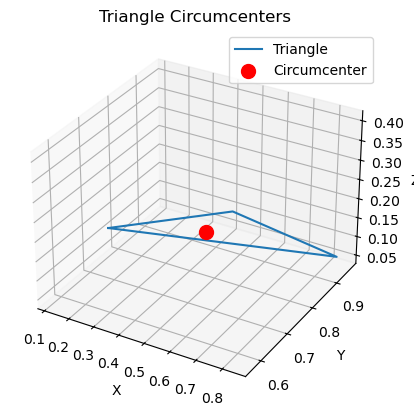

In [110]:
# 检查外心函数到底写得对不对

# 生成随机的三角形
num_triangles = 1
triangles = []
is_obtuse = True
for _ in range(num_triangles):
    while is_obtuse:
        A = np.random.rand(3)  # 随机生成点 A
        B = np.random.rand(3)  # 随机生成点 B
        C = np.random.rand(3)  # 随机生成点 C
        is_obtuse = is_obtuse_triangle(A, B, C)
    triangles.append((A, B, C))

# 计算每个三角形的外心
circumcenters = []
for triangle in triangles:
    circum_center = calculate_triangle_out_circle_center(A, B, C)
    circumcenters.append(circum_center)

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for triangle, circumcenter in zip(triangles, circumcenters):
    A, B, C = triangle
    ax.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], [A[2], B[2], C[2], A[2]], label='Triangle')
    ax.scatter(circumcenter[0], circumcenter[1], circumcenter[2], color='red', s=100, label='Circumcenter')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangle Circumcenters')
ax.legend()

plt.show()


### 2

In [113]:
import numpy as np

# Function to compute the first and second fundamental forms
# 检查过了理解了
def fundamental_forms(a, b, c, u, v):
    # First, we define the parametric surface function for the ellipsoid
    def ellipsoid(u, v):
        return np.array([a * np.cos(u) * np.sin(v), 
                         b * np.sin(u) * np.sin(v), 
                         c * np.cos(v)])
    
    # Compute the partial derivatives for the tangent vectors
    def partial_u(u, v):
        return np.array([-a * np.sin(u) * np.sin(v), 
                          b * np.cos(u) * np.sin(v), 
                          0])
    
    def partial_v(u, v):
        return np.array([a * np.cos(u) * np.cos(v), 
                         b * np.sin(u) * np.cos(v), 
                        -c * np.sin(v)])
    
    # Compute the normal vector by taking the cross product of the partial derivatives
    def normal_vector(u, v):
        return np.cross(partial_u(u, v), partial_v(u, v))
    
    # Normalize the normal vector
    def unit_normal(u, v):
        n = normal_vector(u, v)
        return n / np.linalg.norm(n)
    
    # Compute the second derivatives
    def second_partial_uu(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                          0])
    
    def second_partial_uv(u, v):
        return np.array([-a * np.sin(u) * np.cos(v), 
                          b * np.cos(u) * np.cos(v), 
                         c * np.sin(v)])
    
    def second_partial_vv(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                         -c * np.cos(v)])
    
    # Compute the coefficients of the first fundamental form
    E = np.dot(partial_u(u, v), partial_u(u, v))
    F = np.dot(partial_u(u, v), partial_v(u, v))
    G = np.dot(partial_v(u, v), partial_v(u, v))
    
    # Compute the coefficients of the second fundamental form
    L = np.dot(second_partial_uu(u, v), unit_normal(u, v))
    M = np.dot(second_partial_uv(u, v), unit_normal(u, v))
    N = np.dot(second_partial_vv(u, v), unit_normal(u, v))
    
    return (E, F, G), (L, M, N)

# 还是不理解这里的du和dv是啥意思，为啥这么取
# Function to compute the normal curvature
def normal_curvature(a, b, c, direction_vector):
    # At the point (a,0,0), u = 0 and v = pi/2
    u = np.pi
    v = np.pi / 2
    
    # Compute the first and second fundamental forms at (a,0,0)
    (E, F, G), (L, M, N) = fundamental_forms(a, b, c, u, v)
    
    # Compute the normal curvature using the formula
    # k_n = (Ldu^2 + 2Mdu*dv + Ndv^2) / (Edu^2 + 2Fdu*dv + Gdv^2)
    # For direction vector (du, dv), normalize it first
    # 在该点的局部切平面上的方向向量 (du,dv)。由于这个点在椭球的赤道上，我们可以简单地取 du 和 dv 来代表赤道方向和极点方向
    du, dv = direction_vector
    magnitude = np.sqrt(du**2 + dv**2)
    du, dv = du / magnitude, dv / magnitude
    
    numerator = L*du**2 + 2*M*du*dv + N*dv**2
    denominator = E*du**2 + 2*F*du*dv + G*dv**2
    k_n = numerator / denominator
    
    return k_n

# Let's define the semi-axes of the ellipsoid and the direction vector
a, b, c = 1, 2, 3  # For example, a ellipsoid
direction_vector = (1, 0)  # Example direction, could be any vector on the tangent plane

# Compute the normal curvature at (a,0,0) in the given direction
k_n = normal_curvature(a, b, c, direction_vector)
k_n


0.25

### 3

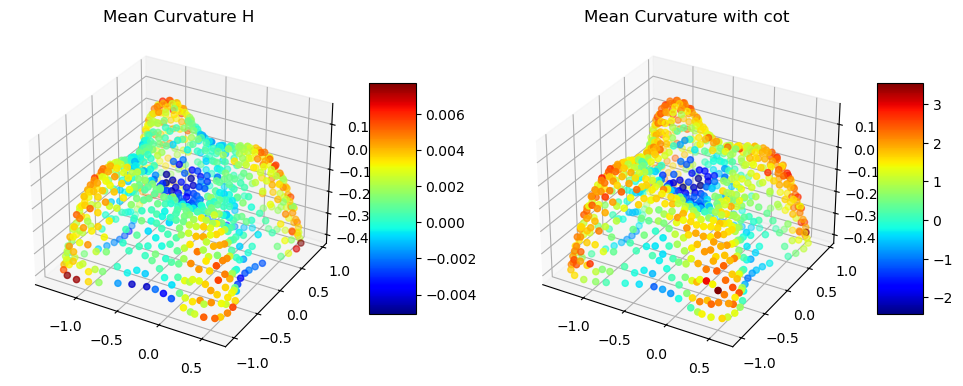

In [176]:
RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

# 函数计算每个顶点的邻居和对边角的余切和面积
def get_vertex_neighbors_and_cotangent(faces, vertices):
    # 初始化邻居和余切权重字典
    vertex_neighbors = {i: set() for i in range(len(vertices))}
    cotangent_weights = {i: {} for i in range(len(vertices))}
    voronoi_areas = np.zeros(len(vertices))

    # 对于每个面，找到共享边的三角形
    for face in faces:
        A, B, C = vertices[face]
        is_obtuse = is_obtuse_triangle(A, B, C)
        if not is_obtuse:
            circum_center = calculate_triangle_out_circle_center(A, B, C)

        # Calculate Voronoi area for each vertex in the face
        for i, vertex in enumerate(face):
            opposite_edge = np.delete(face, i)

            if is_obtuse or  circum_center is None:
                # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
                voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
            else:
                # For non-obtuse triangle, use circumcenter
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
        
        # 对于面中的每个顶点
        for i in range(3):
            # 顶点索引
            v1, v2, v3 = face[i], face[(i + 1) % 3], face[(i + 2) % 3]
            # 顶点坐标
            p1, p2, p3 = vertices[v1], vertices[v2], vertices[v3]
            # 边向量
            edge1, edge2 = p1 - p3, p2 - p3
            # 对边角的余切
            cotangent1 = np.dot(edge1, edge2) / np.linalg.norm(np.cross(edge1, edge2))
            edge1, edge2 = p1 - p2, p3 - p2
            cotangent2 = np.dot(edge1, edge2) / np.linalg.norm(np.cross(edge1, edge2))
            
            # 更新邻居和余切权重
            vertex_neighbors[v1].add(v2)
            vertex_neighbors[v1].add(v3)
            if v2 not in cotangent_weights[v1]:
                cotangent_weights[v1][v2] = 0
            if v3 not in cotangent_weights[v1]:
                cotangent_weights[v1][v3] = 0
            cotangent_weights[v1][v2] += cotangent1
            cotangent_weights[v1][v3] += cotangent2
    
    # 删除重复项并计算最终的余切权重
    for vertex in vertex_neighbors:
        vertex_neighbors[vertex] = list(vertex_neighbors[vertex])
        weights = np.array([cotangent_weights[vertex][neigh] for neigh in vertex_neighbors[vertex]])
        # print(vertex_neighbors[vertex])
        # print(weights)
        cotangent_weights[vertex] = weights

    return vertex_neighbors, cotangent_weights, voronoi_areas


# 计算每个顶点的均值曲率H使用余切权重
def compute_mean_curvature_with_cotangent(vertices, vertex_neighbors, cotangent_weights, normals, voronoi_areas):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        weights = np.array(cotangent_weights[i])  # 确保weights是一个numpy数组
        L = np.sum(neighbor_vectors * weights[:, np.newaxis], axis=0) / (2 * voronoi_areas[i])
        H[i] = - np.dot(L, normals[i]) / 2
    return H

# 可视化曲率
def visualize_curvature(vertices, H1, H2):
    fig = plt.figure(figsize=(12, 6))

    # 可视化均质曲率H
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H1, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)

    # 可视化高斯曲率K
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Mean Curvature with cot")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H2, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)

    plt.show()

# 获取每个顶点的邻居和余切权重
vertex_neighbors, cotangent_weights, voronoi_areas = get_vertex_neighbors_and_cotangent(faces, vertices)
# 计算均值曲率H使用余切离散化
H2 = compute_mean_curvature_with_cotangent(vertices, vertex_neighbors, cotangent_weights, normals, voronoi_areas)
H1 = compute_mean_curvature(vertices, vertex_neighbors, normals)

visualize_curvature(vertices, H1, H2)


### 4

## chatgpt乱写的代码，结果比我认真写半天的ppt结果还好，nm啊

In [194]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

RES_PATH = 'meshes'
mesh_src = os.path.join(RES_PATH, 'decomposition\cow_small_manifold2.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src
# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)


# Function to compute the cotangent Laplace-Beltrami operator for the mesh
def compute_laplacian(vertices, faces):
    # Number of vertices
    n = len(vertices)

    # Initialize weights and matrix indices
    I = []
    J = []
    W = []

    # Iterate over faces to compute cotangent weights
    for face in faces:
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            vi = vertices[face[i]]
            vj = vertices[face[j]]
            vk = vertices[face[k]]
            # Compute cotangents for edges (i, j) and (i, k)
            cot_ij = np.dot(vj - vk, vi - vk) / np.linalg.norm(np.cross(vj - vk, vi - vk))
            cot_ik = np.dot(vj - vi, vj - vk) / np.linalg.norm(np.cross(vj - vi, vj - vk))
            # Append data for the sparse matrix
            I.append(face[i])
            J.append(face[j])
            W.append(cot_ij / 2.0)
            I.append(face[i])
            J.append(face[k])
            W.append(cot_ik / 2.0)

    # Create the sparse matrix
    L = csr_matrix((W, (I, J)), shape=(n, n))
    # Make it symmetric
    L = L + L.T

    # Set the diagonal
    L.setdiag(-np.array(L.sum(axis=1)).flatten())

    return L

# Function to reconstruct the mesh from the Laplacian eigenvalues and eigenvectors
def reconstruct_mesh(vertices, L, k):
    # Compute the k smallest non-zero eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigsh(L, k + 1, which='SM')
    # Ignore the first eigenvector (corresponding to the zero eigenvalue)
    eigenvectors = eigenvectors[:, 1:k + 1]
    # Reconstruct the vertex positions
    vertices_reconstructed = eigenvectors @ eigenvectors.T @ vertices
    return vertices_reconstructed


# Compute the Laplacian
L = compute_laplacian(vertices, faces)

# Perform the reconstructions for k = 5, 15, 50
reconstructed_meshes = {}
for k in [5, 15, 50, 100]:
    reconstructed_vertices = reconstruct_mesh(vertices, L, k)
    reconstructed_meshes[k] = reconstructed_vertices

    # Save the reconstructed mesh to an OBJ file
    output_mesh = trimesh.Trimesh(vertices=reconstructed_vertices, faces=faces)
    output_mesh.export(f'armadillo_reconstructed_k{k}.obj')

print("Reconstruction completed and meshes saved.")


Reconstruction completed and meshes saved.


d:\Python\MniConda3\envs\godzilla\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### 照ppt写的代码，应该没错吧啊啊啊啊啊

In [192]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import scipy.sparse as sp

RES_PATH = 'meshes'
mesh_src = os.path.join(RES_PATH, 'decomposition/cow_small_manifold2.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src
# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

def construct_laplacian(vertex_neighbors, cotangent_weights, voronoi_areas):
    n = len(vertices)
    I = []
    J = []
    C_entries = []
    M_inv_entries = []

    for i in range(n):
        M_inv_entries.append(1.0 / (2.0 * voronoi_areas[i]))
        row_sum = 0
        for j in vertex_neighbors[i]:
            cot_weight = cotangent_weights[i][vertex_neighbors[i].index(j)]
            I.append(i)
            J.append(j)
            C_entries.append(cot_weight)
            row_sum += cot_weight

        I.append(i)
        J.append(i)
        C_entries.append(-row_sum)

    C = sp.csr_matrix((C_entries, (I, J)), shape=(n, n))
    M_inv = sp.diags(M_inv_entries)

    L = M_inv @ C

    return L


# Function to perform the mesh reconstruction using the smallest k eigenvectors
def mesh_reconstruction(vertices, faces, normals, k_values):
    # Get vertex neighbors and cotangent weights
    vertex_neighbors, cotangent_weights, voronoi_areas = get_vertex_neighbors_and_cotangent(faces, vertices)
    
    # Construct the Laplacian matrix
    n_vertices = len(vertices)
    L = construct_laplacian(vertex_neighbors, cotangent_weights, voronoi_areas)
    
    # Perform eigen decomposition and reconstruct the mesh for each k
    reconstructions = {}
    for k in k_values:
        eigenvalues, eigenvectors = eigsh(L, k + 1, which='SM')
        eigenvectors = eigenvectors[:, 1:k+1]
        reconstruction = eigenvectors @ eigenvectors.T @ vertices
        reconstructions[k] = reconstruction

    return reconstructions


# Perform the reconstructions for k = 5, 15, 50
k_values = [5, 15, 50, 200]
reconstructions = mesh_reconstruction(vertices, faces, normals, k_values)

# Save the reconstructed meshes and provide file paths
output_files = {}
for k, recon_verts in reconstructions.items():
    # Create a new mesh with the reconstructed vertices
    recon_mesh = trimesh.Trimesh(vertices=recon_verts, faces=faces, process=False)
    recon_mesh.export(f'cow_reconstructed_k{k}.obj')

output_files


{}